Artificial Neurons and Single-Layer Neural Networks
===

Ruby translation of Python code in Sebastian Raschka's blog post [Artificial Neurons and Single-Layer Neural Networks](http://sebastianraschka.com/Articles/2015_singlelayer_neurons.html)

In [1]:
require 'nmatrix/nmatrix'
require './utils/nmatrix_ext'
require 'gnuplot'
require './utils/gnuplot_helper'
require 'csv'

true

Implementing the Perceptron Rule in Ruby
---

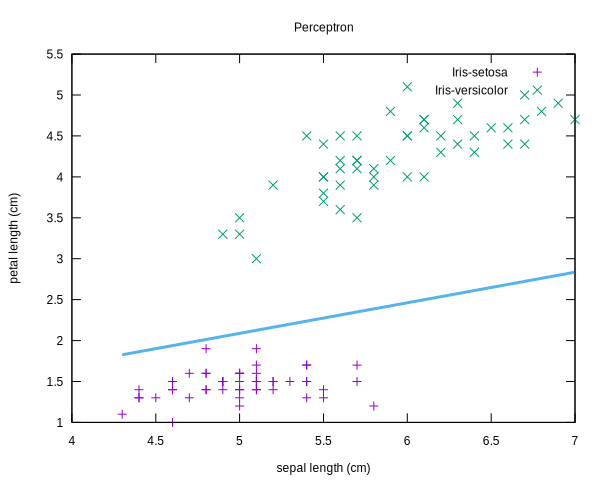

weights
-0.4
-0.6799999999999995
1.82


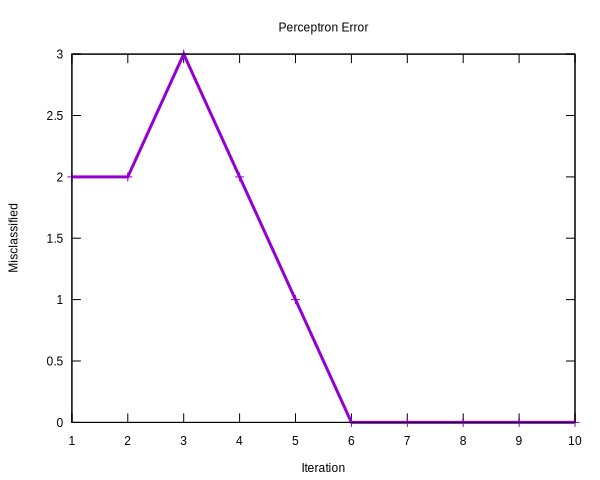

In [2]:
class Perceptron
  attr_reader :weights, :errors

  def initialize(eta: 0.01, epochs: 50)
    @eta = eta
    @epochs = epochs
  end

  def train(x, y)
    @weights = N.zeros([1, 1 + x.cols])
    @errors = []

    @epochs.times do
      errors = 0
      x.each_row.with_index do |row, i|
        target = y[i]
        update = @eta * (target - predict(row))
        @weights[1..-1] += row * update
        @weights[0] += update
        errors += 1 if update != 0.0
      end
      @errors << errors
    end
    self
  end

  def net_input(x)
    (x.dot(@weights[1..-1].transpose))[0] + @weights[0]
  end

  def predict(x)
    net_input(x) >= 0 ? 1 : -1
  end
end


csv = CSV.read 'data/iris.data'
data = csv.map {|row| row[0..3].map(&:to_f) }.to_nm
labels = csv.map {|row| row[4] }.to_nm


species = {'Iris-setosa' => -1, 'Iris-versicolor' => 1}
mask = labels.map {|v| species.has_key?(v) }
x = data.row(mask).col([0,2]) # cols [0,2] == sepal length and petal length
y = labels.row(mask).map {|v| species[v] }


# Train

ppn = Perceptron.new(epochs: 10, eta: 0.1).train(x, y)


# Display Results

decision_plot ppn.weights, species.map {|k,v| [x.row(y =~ v), k] } do |plot|
  plot.title 'Perceptron'
  plot.xlabel 'sepal length (cm)'
  plot.ylabel 'petal length (cm)'
end

IRuby.display IRuby.table weights: ppn.weights.to_a

cost_plot ppn.errors do |plot| 
  plot.title 'Perceptron Error'
  plot.xlabel 'Iteration'
  plot.ylabel 'Misclassified'
end

Problems with Perceptrons
---

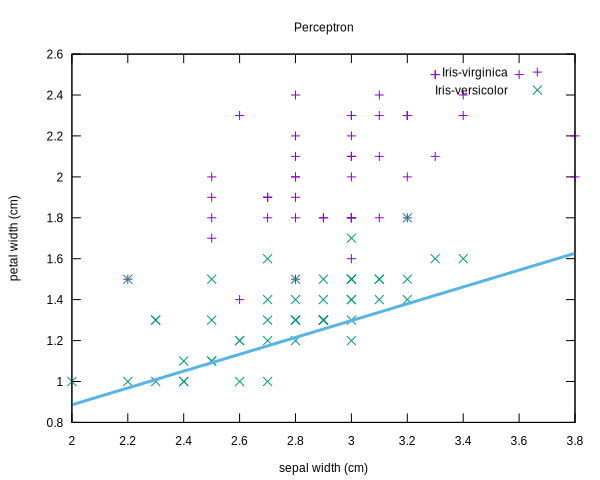

weights
0.02
0.13000000000000006
-0.3160000000000001


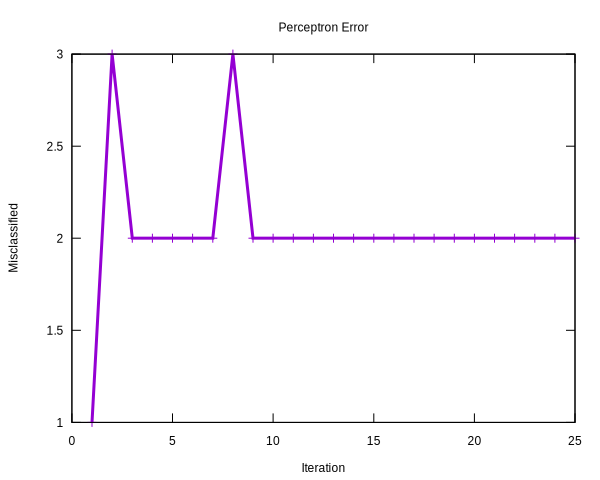

In [3]:
species = {'Iris-virginica' => -1, 'Iris-versicolor' => 1}
mask = labels.map {|v| species.has_key?(v) }
x2 = data.row(mask).col([1,3]) # cols [1,3] == sepal width and petal width
y2 = labels.row(mask).map {|v| species[v] }


# Train

ppn2 = Perceptron.new(epochs: 25, eta: 0.01).train(x2, y2)


# Display Results

decision_plot ppn2.weights, species.map {|k,v| [x2.row(y2 =~ v), k] } do |plot|
  plot.title 'Perceptron'
  plot.xlabel 'sepal width (cm)'
  plot.ylabel 'petal width (cm)'
end

IRuby.display IRuby.table weights: ppn2.weights.to_a

cost_plot ppn2.errors do |plot| 
  plot.title 'Perceptron Error'
  plot.xlabel 'Iteration'
  plot.ylabel 'Misclassified'
end

The Gradient Descent Rule in Action
---

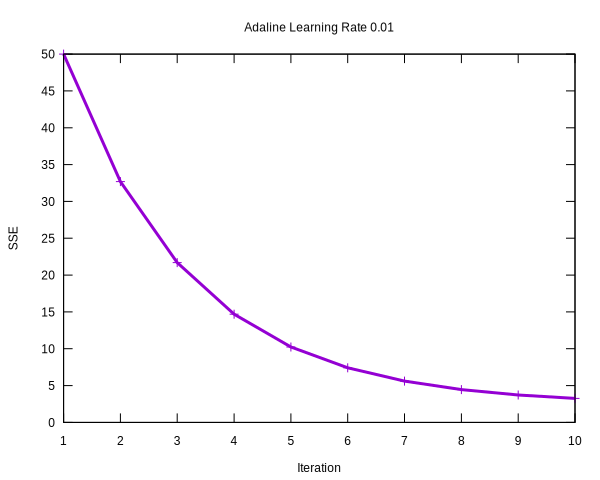

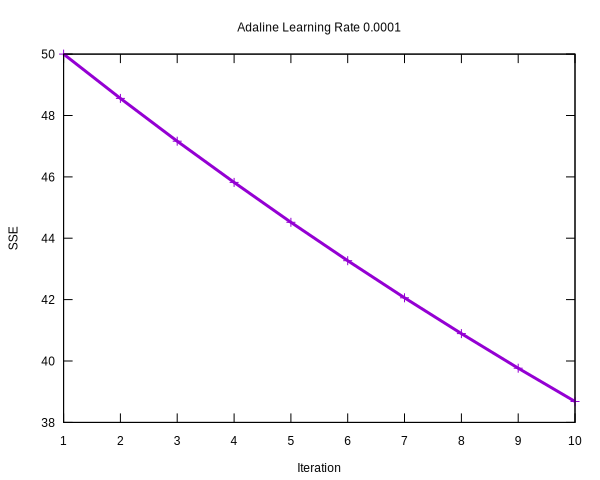

In [4]:
class AdalineGD
  attr_reader :weights, :cost

  def initialize(eta: 0.01, epochs: 50)
    @eta = eta
    @epochs = epochs
  end

  def train(x, y)
    @weights = N.zeros([1 + x.cols, 1])
    @cost = []

    y = y.reshape([y.count, 1])

    @epochs.times do
      output = net_input(x)
      errors = (y - output)
      @weights[1..-1] += x.transpose.dot(errors) * @eta
      @weights[0] += errors.sum[0] * @eta
      cost = (errors**2).sum[0] / 2.0
      @cost << cost
    end
    self
  end

  def net_input(x)
    x.dot(@weights[1..-1]) + @weights[0]
  end

  def activation(x)
    net_input(x)
  end

  def predict(x)
    activation(x).map {|v| v >= 0 ? 1 : -1}
  end
end


x = x.standardize_columns


# Train

ada01 = AdalineGD.new(epochs: 10, eta: 0.01).train(x, y)
ada0001 = AdalineGD.new(epochs: 10, eta: 0.0001).train(x, y)


# Display Results

cost_plot ada01.cost do |plot| 
  plot.title 'Adaline Learning Rate 0.01'
  plot.xlabel 'Iteration'
  plot.ylabel 'SSE'
end

cost_plot ada0001.cost do |plot| 
  plot.title 'Adaline Learning Rate 0.0001'
  plot.xlabel 'Iteration'
  plot.ylabel 'SSE'
end

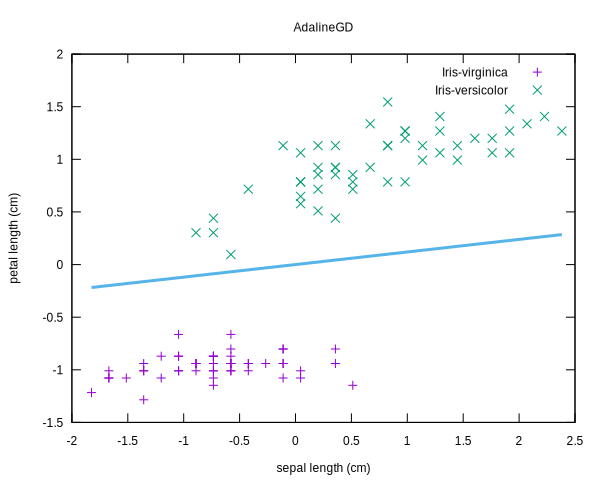

weights
[-3.053113317719178e-16]
[-0.1318723399086629]
[1.1033582365565646]


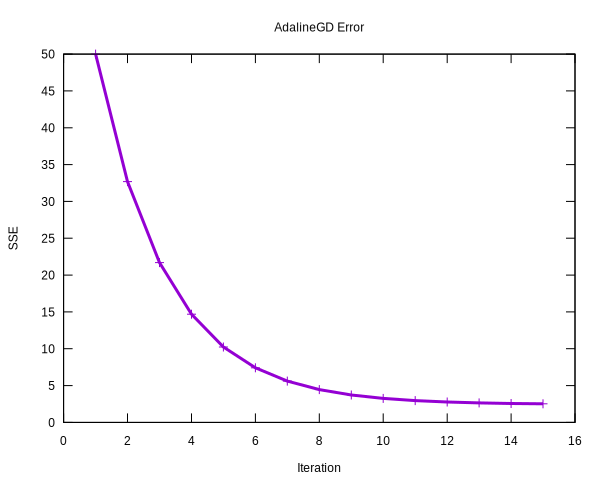

In [5]:
# Train

ada = AdalineGD.new(epochs: 15, eta: 0.01).train(x, y)


# Display Results

decision_plot ada.weights, species.map {|k,v| [x.row(y =~ v), k] } do |plot|
  plot.title 'AdalineGD'
  plot.xlabel 'sepal length (cm)'
  plot.ylabel 'petal length (cm)'
end

IRuby.display IRuby.table weights: ada.weights.to_a

cost_plot ada.cost do |plot| 
  plot.title 'AdalineGD Error'
  plot.xlabel 'Iteration'
  plot.ylabel 'SSE'
end

Online Learning via Stochastic Gradient Descent
---

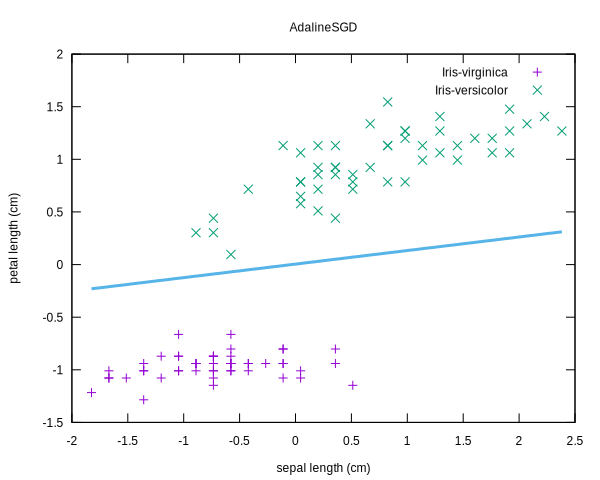

weights
[-0.004760204202120943]
[-0.13808921218243606]
[1.0729340892045365]


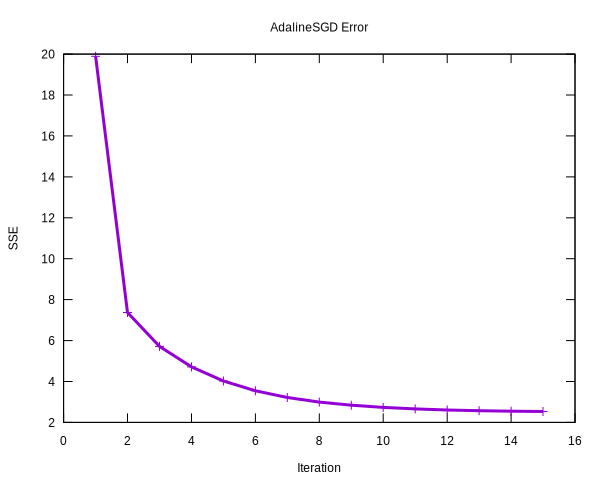

In [6]:
class AdalineSGD
  attr_reader :cost, :weights

  def initialize(eta: 0.01, epochs: 50)
    @eta = eta
    @epochs = epochs
  end

  def train(x, y, reinitialize_weights = true)

    if reinitialize_weights
      @weights = N.zeros([1 + x.cols, 1])
    end

    @cost = []

    y = y.reshape([y.count, 1])

    @epochs.times do
      errors = []
      x.each_row.with_index do |row, i|
        target = y[i]
        output = net_input(row)
        error = target - output[0]
        errors << error
        update  = row * error * @eta
        @weights[1..-1] += update.transpose
        @weights[0] += error * @eta
      end

      cost = errors.map {|e| e**2}.reduce(:+) / 2.0
      @cost << cost
    end

    self
  end

  def net_input(x)
    x.dot(@weights[1..-1]) + @weights[0]
  end

  def activation(x)
    net_input(x)
  end

  def predict(x)
    activation(x).map {|v| v >= 0 ? 1 : -1}
  end
end


shuffled_indexes = x.rows.times.to_a.shuffle

x_shuf = x.row(shuffled_indexes)
y_shuf = y.row(shuffled_indexes)

x_shuf.standardize_columns!


# Train

ada = AdalineSGD.new(epochs: 15, eta: 0.01).train(x_shuf, y_shuf)


# Display Results

decision_plot ada.weights, species.map {|k,v| [x_shuf.row(y_shuf =~ v), k] } do |plot|
  plot.title 'AdalineSGD'
  plot.xlabel 'sepal length (cm)'
  plot.ylabel 'petal length (cm)'
end

IRuby.display IRuby.table weights: ada.weights.to_a

cost_plot ada.cost do |plot| 
  plot.title 'AdalineSGD Error'
  plot.xlabel 'Iteration'
  plot.ylabel 'SSE'
end